In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

match = pd.read_csv('datasets/dota-2-matches/match.csv')
player_time = pd.read_csv('datasets/dota-2-matches/player_time.csv')

**player_time**: Contains last hits, experience, and gold sampled at one minute interval for all players in all matches. The column names indicate the player_slot. For instance `xp_t_1` indicates that this column has experience sums for the player in slot one.

In [2]:
player_time.head()

,match_id,times,gold_t_0,lh_t_0,xp_t_0,gold_t_1,lh_t_1,xp_t_1,gold_t_2,lh_t_2,...,xp_t_129,gold_t_130,lh_t_130,xp_t_130,gold_t_131,lh_t_131,xp_t_131,gold_t_132,lh_t_132,xp_t_132
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,60,409,0,63,142,1,186,168,0,...,62,345,6,351,100,0,77,613,1,125
2,0,120,546,0,283,622,4,645,330,0,...,543,684,12,805,200,0,210,815,5,323
3,0,180,683,1,314,927,9,1202,430,0,...,842,958,16,1135,300,0,210,1290,8,527
4,0,240,956,1,485,1264,11,1583,530,0,...,1048,1500,26,1842,400,0,210,1431,9,589


In [3]:
radiant_gold = player_time[['gold_t_0', 'gold_t_1', 'gold_t_2', 'gold_t_3', 'gold_t_4']]
dire_gold = player_time[['gold_t_128', 'gold_t_129', 'gold_t_130', 'gold_t_131', 'gold_t_132']]

player_gold = pd.DataFrame(columns=["match_id", "gold_radiant", "gold_dire"])
player_gold["gold_radiant"] = radiant_gold.sum(axis=1)
player_gold["gold_dire"] = dire_gold.sum(axis=1)
player_gold["match_id"] = player_time["match_id"]
player_gold["times"] = player_time["times"]

In [4]:
player_gold_merged = player_gold.merge(match, on='match_id')[['match_id', 'times', 'gold_radiant', 'gold_dire', 'radiant_win']]
player_gold_merged['time_min'] = player_gold_merged['times']/60
player_gold_merged['gold_difference'] = player_gold_merged['gold_dire'] - player_gold_merged['gold_radiant']
player_gold_merged['radiant_lead'] = player_gold_merged['gold_difference'] < 0
player_gold_merged.head()

,match_id,times,gold_radiant,gold_dire,radiant_win,time_min,gold_difference,radiant_lead
0,0,0,0,0,True,0.0,0,False
1,0,60,1113,1370,True,1.0,257,False
2,0,120,2471,2726,True,2.0,255,False
3,0,180,3490,4057,True,3.0,567,False
4,0,240,4950,5500,True,4.0,550,False


<AxesSubplot:xlabel='gold_radiant', ylabel='gold_dire'>

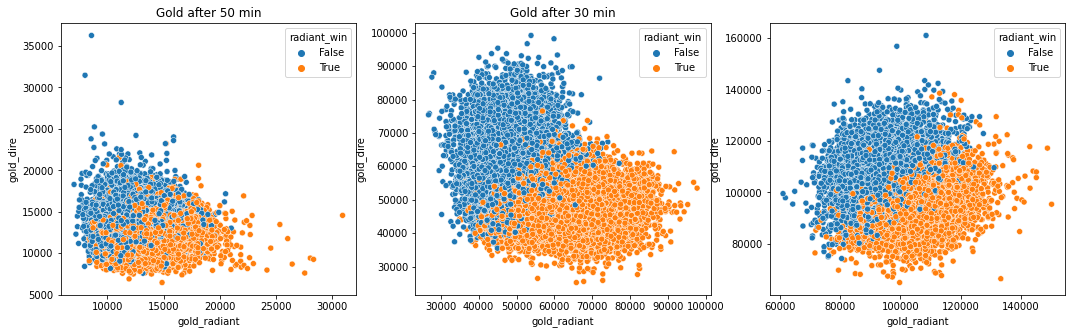

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18,5))
ax[0].set_title("Gold after 10 min")
sns.scatterplot(ax=ax[0], data=player_gold_merged[player_gold_merged['time_min'] == 10], x='gold_radiant', y='gold_dire', hue='radiant_win')
ax[1].set_title("Gold after 30 min")
sns.scatterplot(ax=ax[1], data=player_gold_merged[player_gold_merged['time_min'] == 30], x='gold_radiant', y='gold_dire', hue='radiant_win')
ax[0].set_title("Gold after 50 min")
sns.scatterplot(ax=ax[2], data=player_gold_merged[player_gold_merged['time_min'] == 50], x='gold_radiant', y='gold_dire', hue='radiant_win')

We can see in the scatter plots that there seems to be a strong correlation between the gold that a team has and its win probability.

<AxesSubplot:title={'center':'Gold lead to win percentage'}, xlabel='Time (minutes)', ylabel='Percentage'>

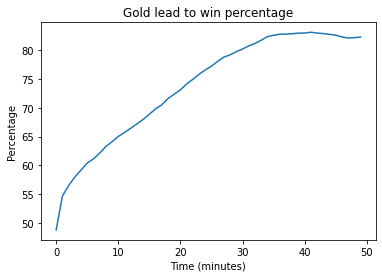

In [6]:
def lead_to_win_percentage(time):
    data = player_gold_merged[player_gold_merged['time_min'] == time]
    return np.sum(data['radiant_lead']==data['radiant_win'])/data.shape[0]*100

lead_to_win_percent = []
for i in range(0,50):
    lead_to_win_percent.append(lead_to_win_percentage(i))

plt.title("Gold lead to win percentage")
plt.xlabel("Time (minutes)")
plt.ylabel("Percentage")
sns.lineplot(x=range(0,50), y=lead_to_win_percent)

We can see from this graph that being in the gold lead can have a strong effect on the win percentage. Just 5 minutes past the start of the game, around 60% teams in the gold lead won. At the 40 minute mark, this percentage goes up to almost 85%. We can also check what is the proportion of teams that won the match while being in the gold lead.

In [7]:
player_gold_match_end = player_gold_merged.merge(match, on='match_id')
data = player_gold_match_end[player_gold_match_end['times']==player_gold_match_end['duration']]
percentage = np.sum(data['radiant_lead']==data['radiant_win_x'])/data.shape[0]*100
print(f"{percentage:.2f}% teams won with a gold lead at the end of the match.")

98.40% teams won with a gold lead at the end of the match.


In [8]:
player_gold_merged

,match_id,times,gold_radiant,gold_dire,radiant_win,time_min,gold_difference,radiant_lead
0,0,0,0,0,True,0.0,0,False
1,0,60,1113,1370,True,1.0,257,False
2,0,120,2471,2726,True,2.0,255,False
3,0,180,3490,4057,True,3.0,567,False
4,0,240,4950,5500,True,4.0,550,False
...,...,...,...,...,...,...,...,...
2209773,49999,2640,88810,113934,False,44.0,25124,False
2209774,49999,2700,89979,114434,False,45.0,24455,False
2209775,49999,2760,91311,117625,False,46.0,26314,False
2209776,49999,2820,91556,123044,False,47.0,31488,False


In [9]:
def create_dataset(game_duration):
    # Get match_id's for games that lasted atleast as long as `game_duration`
    game_duration_matches = player_gold_match_end[player_gold_match_end['duration'] > game_duration*60]['match_id'].unique()

    X = np.empty((len(game_duration_matches), 2*game_duration))
    y = np.full((len(game_duration_matches)), False)
    
    for idx, match_id in enumerate(game_duration_matches):
        data = player_gold_merged[player_gold_merged['match_id']==match_id]
        gold = np.concatenate([data['gold_radiant'].to_numpy().reshape(1, data['gold_radiant'].shape[0])[0][:game_duration],
                               data['gold_dire'].to_numpy().reshape(1, data['gold_dire'].shape[0])[0][:game_duration]])
        y[idx] = data['radiant_win'].iat[0]
        X[idx] = gold
    
    return X, y

In [10]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from joblib import parallel_backend

score_dict = {}

for game_duration in [5,10,15,20,25,30,35,40,45,50,55,60]:
    X, y = create_dataset(game_duration)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)
    clf = LogisticRegressionCV(max_iter=5000)
    with parallel_backend('threading', n_jobs=8):
        clf.fit(X_train, y_train)
        train_score = clf.score(X_train, y_train)
        test_score = clf.score(X_test, y_test)
    score_dict[game_duration] = (train_score, test_score)

In [41]:
score_dict
for key, value in score_dict.items():
    print(f"Game time: {key:02d} min | Train score: {value[0]:.3f} | Test score: {value[1]:.3f}")

Game time: 05 min | Train score: 0.597 | Test score: 0.593
Game time: 10 min | Train score: 0.641 | Test score: 0.639
Game time: 15 min | Train score: 0.682 | Test score: 0.679
Game time: 20 min | Train score: 0.724 | Test score: 0.727
Game time: 25 min | Train score: 0.765 | Test score: 0.763
Game time: 30 min | Train score: 0.783 | Test score: 0.787
Game time: 35 min | Train score: 0.800 | Test score: 0.799
Game time: 40 min | Train score: 0.792 | Test score: 0.800
Game time: 45 min | Train score: 0.777 | Test score: 0.767
Game time: 50 min | Train score: 0.756 | Test score: 0.751
Game time: 55 min | Train score: 0.721 | Test score: 0.715
Game time: 60 min | Train score: 0.710 | Test score: 0.645


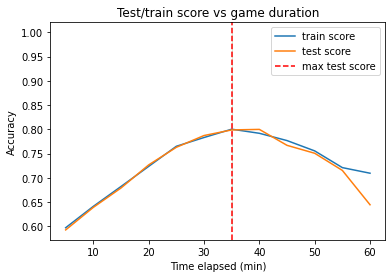

In [27]:
sns.lineplot(x=score_dict.keys(), y=[x[0] for x in score_dict.values()], label="train score")
sns.lineplot(x=score_dict.keys(), y=[x[1] for x in score_dict.values()], label="test score")
sns.lineplot(x=5*np.argmax([x[1] for x in score_dict.values()]), y=[0.6,1])
plt.axvline(x=5*np.argmax([x[1] for x in score_dict.values()]), c='red', linestyle='dashed', label="max test score")
plt.title('Test/train score vs game duration')
plt.xlabel('Time elapsed (min)')
plt.ylabel('Accuracy')
plt.legend()

We can see that we get a model that predicts the win with 80% accuracy based on the gold levels of the teams just 35 minutes after game start. We can get pretty good estimates with shorted durations as well. This result also affirms the earlier observation that the gold levels stop being strong predictors as more time passes.